# Online surveillance and Wikipedia use

Our 3 research questions are the following:
- Can we observe chilling effects on Wikipedia access data even if we use a longer time frame for the analysis?
- Are there chilling effects on Wikipedia accross different languages?
- Can we observe chilling effects on Google Trends as well?

In order to answer them, we need to retrieve access data from Wikipedia and Google Trends.

For Wikipedia, we use the R library `wikipediatrend` which allows to collect pageviews for different languages and over a long period of time.
A notable flaw with this library is that it uses two different APIs to retrieve data:
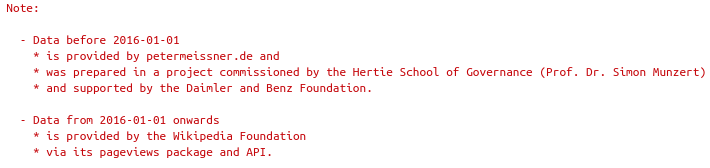
However, this is due to the fact that the official API to retrieve Wikipedia pageviews only appeared in January 2016, so this is a problem we couldn't overcome.

Inside the `utils` folder, we have the R script `translating_topics.R` which allowed us to translate the Wikipedia article names for the set of 30 terrorism-related and 25 domestic security-related articles to German, French, Italian, Spanish and Portuguese, and then we retrieved the pageviews for the articles in all these languages using `scrapping_wikipedia.R`.
An important point to take into account is that some of the Wikipedia articles mentioned in the paper changed name or were merged with others (namely suicide_bomber and suicide_attack were grouped together under the latter's name), and as such we do not have exactly the same groups of articles as in the paper.

For Google Trends, we use the `GTAB` library from the `DLAB` later on in the notebook, though we have also defined a helper class `TrendsQuerier` inside the file `utils/query_google.py`.

## Imports & Constants

In [2]:
import datetime
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import statsmodels.formula.api as smf

from utils.query_google import TrendsQueryer
from utils.plot_split_timeseries import split_timeseries_figures

## Querying Google Trends

Using our prepared utility functions to query relevant keywords from google trends, using the dlabs GTAB library.

In [3]:
def install_requirements():
    import sys
    !{sys.executable} -m pip install gtab  # Has to be checked first or else gtab is imported as module from the data folder gtab
    !{sys.executable} -m pip install jupyter-dash
    !{sys.executable} -m pip install plotly
    !{sys.executable} -m pip install jupyterlab "ipywidgets>=7.5"

In [152]:
import gtab
# install_requirements()

In [3]:
PRISM_DATE = datetime.datetime(2013, 6, 6)

# GTAB information
TIMEFRAME = '2012-01-01 2014-08-31'
GEO_CODES = ['', 'ar', 'de', 'es', 'fr', 'hi', 'it', 'ja', 'pt', 'ru']

GOOGLE_DATA = 'data/google-trends'
WIKI_DATA = 'data/wikipedia'

In [4]:
all_google_trends = {}
# for location in GEO_CODES:
#     try:
#         gt = TrendsQueryer(TIMEFRAME, geo_code=location)
#         location_code = location if location != '' else 'en'
#         gt_terror = gt.load_or_query('terrorism_' + location_code)
#         gt_domestic = gt.load_or_query('domestic_' + location_code)
#         all_google_trends[location] = {'terror': gt_terror, 'domestic': gt_domestic}
#     # Usually, we want the WorldWide data:
#     except ConnectionError as exe:
#         "Skipping {}. {}".format(location, exe)
gt = TrendsQueryer(TIMEFRAME, geo_code='')
gt_terror = gt.load_or_query('terrorism_en')
gt_domestic = gt.load_or_query('domestic_en')

Directory already exists, loading data from it.
Using directory '/home/jonathan/Documents/ada-2020-project-milestone-p3-p3_0x414441/gtab/'
Active anchorbank changed to: google_anchorbank_geo=_timeframe=2019-01-01 2020-08-01.tsv

Active anchorbank changed to: google_anchorbank_geo=_timeframe=2011-01-01 2015-12-31.tsv

Loaded terrorism_en.csv
Loaded domestic_en.csv


In [5]:
gt_terror.sample(frac=1).head()

article        date  max_ratio  max_ratio_hi  max_ratio_lo  \
5737    Suicide attack  2015-11-29   0.051142      0.054528      0.047919   
1508  Ammonium nitrate  2014-11-23   0.180000      0.185000      0.175000   
5640    Suicide attack  2014-01-19   0.026917      0.029361      0.024607   
7472            attack  2014-02-23  34.753355     38.414593     31.450137   
8453         hezbollah  2012-12-09   0.246753      0.254902      0.238710   

     lanuage  
5737  en.csv  
1508  en.csv  
5640  en.csv  
7472  en.csv  
8453  en.csv

#### Concatenate the dataframes to one:

In [6]:
# Concatenate the dataframes into one
gt_terror['topic'] = 'terror'
gt_domestic['topic'] = 'domestic'
google = pd.concat([gt_terror, gt_domestic])
# Create a column that simplifies the month and only leaves the month
google['date'] = pd.to_datetime(google['date'])
google['month'] = google.date.dt.to_period('M')

In [185]:
wiki_layout = {'yaxis_title': 'Cumulated page views', 'xaxis_title': 'Month'}
google_layout = {'yaxis_title': 'Cumulated Google Trends Rating', 'xaxis_title': 'Month'}

In [ ]:
# The Plottly function
def analyse_and_plot(dataset='wikipedia', lang=None, ignore_months=range(54, 61), split=None, layout=None, seperate_y=False, start_at=None, end_at=None):
    """
    (month 42 is June 2013 since the data starts in January 2010)
    """
    
    # Read both csv files
    if dataset == 'wikipedia':
        df_terrorism = pd.read_csv(f'data/wikipedia/terrorism_views.csv')
        df_domestic = pd.read_csv(f'data/wikipedia/domestic_views.csv')
        yax = 'views'
    elif dataset in ['google', 'google-trends']:
        df_terrorism = pd.read_csv(f'data/google-trends/terrorism_en.csv')
        df_domestic = pd.read_csv(f'data/google-trends/domestic_en.csv')
        yax = 'max_ratio'
    else:
        raise ValueError("Unknown dataset")
    
    # Group them
    df = pd.concat([df_terrorism, df_domestic])
    
    # Create a mapping from article name to study group
    group = {}
    for article in df_terrorism.article.unique():
        group[article] = 'terrorism'
    for article in df_domestic.article.unique():
        group[article] = 'domestic'
    
    if lang is not None:
        # Keep only articles in this language
        df = df.loc[df.language == lang]
    
    if start_at is not None:
        df = df.loc[pd.to_datetime(df.date) >= start_at]
    if end_at is not None:
        df = df.loc[pd.to_datetime(df.date) <= end_at]
    
    # We extract the month, year, time (number of months elapsed since the beginning of the period)
    df['month'] = pd.DatetimeIndex(df.date).month
    df['year'] = pd.DatetimeIndex(df.date).year
    df['time'] = (df.year - df.year.min()) * 12 + df.month
    if split is None:
        split = (2013 - df.year.min()) * 12 + 7 - df.loc[df.year == df.year.min()].month.min()
    
    # Get the total number of views for each article for each month
    monthly_views = df.groupby(['article', 'time'])[yax].sum().reset_index()\
                                  .pivot_table(index='article', columns='time', values=yax)
    
    # Retrieve the monthly pageviews for each article group
    terrorism_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'terrorism')]
    domestic_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'domestic')]
    
    # DataFrame to apply the ITS analysis to
    its = pd.DataFrame()

    # Monthly number of views aggregated over all terrorism articles
    its['t_views'] = terrorism_views.sum()
    # Monthly number of views aggregated over all terrorism articles
    its['d_views'] = domestic_views.sum()

    # Indicator of whether the NSA revelations have already happened
    its['NSA'] = (its.index.to_series() >= split).astype(int)
    # We just do this to be able to use the column 'month' in the regression
    its['month'] = its.index
    its = its.drop(index=split)
    
    # Fitting the ITS regressions
    terrorism_regr = smf.ols(formula='t_views ~ month * NSA', data=its.drop(index=ignore_months)).fit()
    domestic_regr = smf.ols(formula='d_views ~ month * NSA', data=its.drop(index=ignore_months)).fit()
    
    # Retrieve the ITS predictions and confidence intervals
    its['t_pred'] = terrorism_regr.predict(its)
    its[['t_low', 't_high']] = terrorism_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values
    its['d_pred'] = domestic_regr.predict(its)
    its[['d_low', 'd_high']] = domestic_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values    
    
    ## Plotting
    if seperate_y:
        fig = make_subplots(specs=[[{"secondary_y": True}]])
    else:
        fig = go.Figure()
    hovertemplate = '<b>Views</b>: %{y:.2f}' + '<br>Month: %{x}<br>'

    # Plot the regression confidence intervals
    x = its.loc[:split-1, 't_pred'].index
    fig.add_trace(go.Scatter(x=x.append(x[::-1]), y=its.loc[:split-1, 't_high'].append(its.loc[:split-1, 't_low'][::-1]),
                             fill='toself', fillcolor='rgba(64,144,248,0.15)', mode='none', showlegend=False))
    x = its.loc[split:, 't_pred'].index
    fig.add_trace(go.Scatter(x=x.append(x[::-1]), y=its.loc[split+1:, 't_high'].append(its.loc[split:, 't_low'][::-1]),
                             fill='toself', fillcolor='rgba(64,144,248,0.15)', mode='none', showlegend=False))
    x = its.loc[:split-1, 'd_pred'].index
    dom_fill_before = go.Scatter(x=x.append(x[::-1]), y=its.loc[:split-1, 'd_high'].append(its.loc[:split-1, 'd_low'][::-1]), 
                                 fill='toself', fillcolor='rgba(255,130,0,0.15)', mode='none', showlegend=False)
    x = its.loc[split:, 'd_pred'].index
    dom_fill_after = go.Scatter(x=x.append(x[::-1]), y=its.loc[split+1:, 'd_high'].append(its.loc[split:, 'd_low'][::-1]), 
                                fill='toself', fillcolor='rgba(255,130,0,0.15)', mode='none', showlegend=False)
    if seperate_y:
        fig.add_trace(dom_fill_before, secondary_y=True)
        fig.add_trace(dom_fill_after, secondary_y=True)
    else:
        fig.add_trace(dom_fill_before)
        fig.add_trace(dom_fill_after)
        
        
    # Plot the terror regression line before and after the June 2013 revelations (June 2013 excluded)
    fig.add_trace(go.Scatter(x=its.loc[:split-1, 't_pred'].index, y=its.loc[:split-1, 't_pred'],
                             name='Trend before NSA revelations', line={'color': 'black'}))
    fig.add_trace(go.Scatter(x=its.loc[split:, 't_pred'].index, y=its.loc[split+1:, 't_pred'],
                             name='Trend after NSA revelations', line={'color': 'black', 'dash': 'dash'}))

    # Plot the domestic regression line before and after the June 2013 revelations (June 2013 excluded)
    dom_reg_before = go.Scatter(x=its.loc[:split-1, 'd_pred'].index, y=its.loc[:split-1, 'd_pred'], 
                                name='Trend before NSA revelations', line={'color': 'black'}, showlegend=False)
    dom_reg_after = go.Scatter(x=its.loc[split:, 'd_pred'].index, y=its.loc[split+1:, 'd_pred'], 
                               name='Trend after NSA revelations', line={'color': 'black', 'dash': 'dash'}, showlegend=False)
    if seperate_y:
        fig.add_trace(dom_reg_before, secondary_y=True)
        fig.add_trace(dom_reg_after, secondary_y=True)
    else:
        fig.add_trace(dom_reg_before)
        fig.add_trace(dom_reg_after)
        
    # Plot the actual monthly pageviews as dots
    fig.add_trace(go.Scatter(x=its['t_views'].drop(index=ignore_months).index, y=its['t_views'].drop(index=ignore_months),
                             mode='markers', name='Terrorism article ' + yax, marker_color='rgba(64,144,248,1)', marker_size=8,
                             hovertemplate=hovertemplate))
    fig.add_trace(go.Scatter(x=its['t_views'].loc[ignore_months].index, y=its['t_views'].loc[ignore_months],
                             mode='markers', name='Ignored terrorism article ' + yax, marker_color='rgba(64,144,248,0.6)', marker_size=7,
                             hovertemplate=hovertemplate))

    dom_scatter = go.Scatter(x=its['d_views'].drop(index=ignore_months).index, y=its['d_views'].drop(index=ignore_months),
                             mode='markers', name='Domestic article ' + yax, marker_color='rgba(255,130,0,1)', marker_size=8,
                             hovertemplate=hovertemplate)
    dom_ignore = go.Scatter(x=its['d_views'].loc[ignore_months].index, y=its['d_views'].loc[ignore_months],
                             mode='markers', name='Ignored domestic article ' + yax, marker_color='rgba(255,130,0,0.6)', marker_size=7,
                             hovertemplate=hovertemplate)
    if seperate_y:
        fig.add_trace(dom_scatter, secondary_y=True)
        fig.add_trace(dom_ignore, secondary_y=True)
    else:
        fig.add_trace(dom_scatter)
        fig.add_trace(dom_ignore)
        
    # Show the moment of the NSA revelations
    fig.add_shape(type="line", yref='paper', x0=split, y0=0, x1=split, y1=1, line=dict(color="Red",width=2, dash='dash'))

    # Set layout, title, axis labels, x ticks
    lang = f'[{lang}] ' if lang is not None else ''
    title = lang + 'Terrorism study group (25 articles) vs Domestic security comparator group (24 articles), {}'.format(dataset)
    fig.update_layout(title=title)
    fig.update_xaxes(nticks=40, ticks="inside", showgrid=False, showline=True, linewidth=2, linecolor='black', mirror=True)
    fig.update_yaxes(nticks=10, ticks="inside", showline=True, linewidth=2, linecolor='black', mirror=True)
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)',
                      height=600)
    
    if layout is not None:
        fig.update_layout(layout)
    
    return (terrorism_regr, domestic_regr), fig

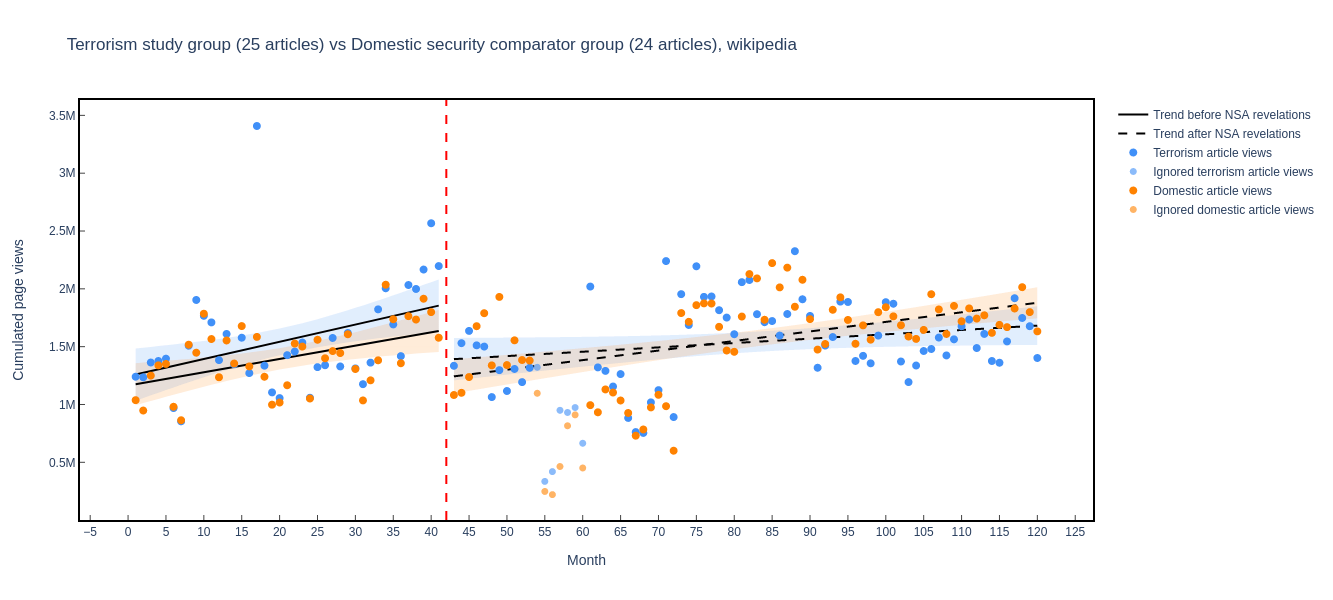

In [188]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', layout=wiki_layout)
fig.show()
fig.write_html("./sample_plot.html")

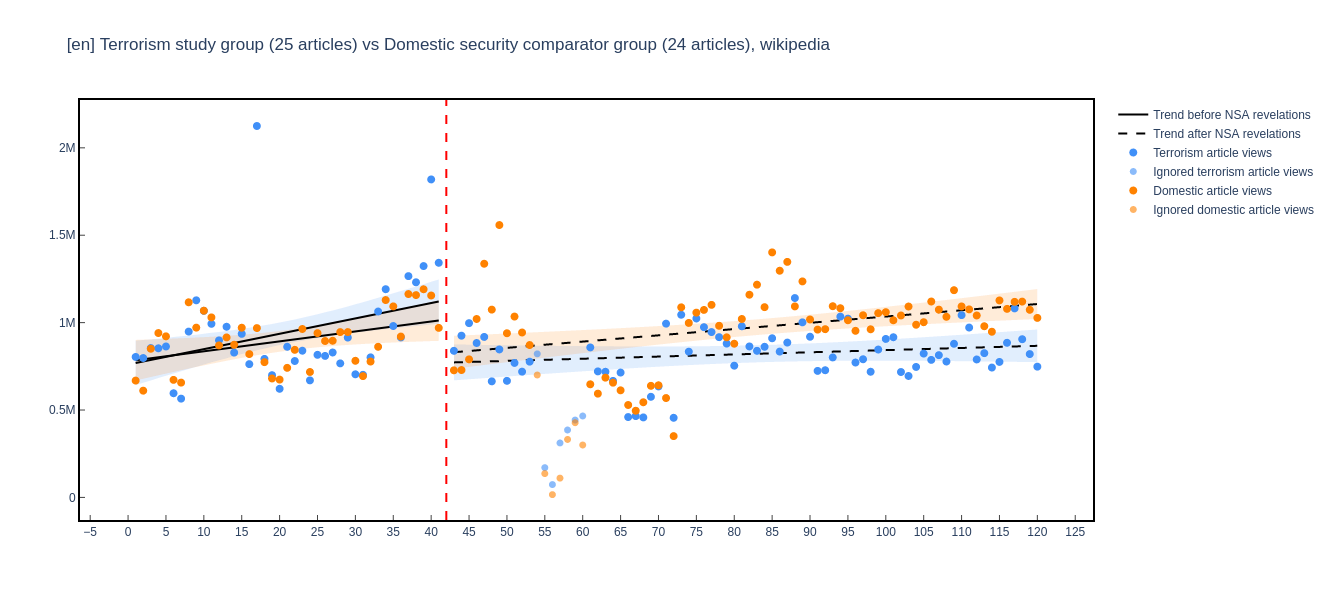

In [133]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='en')
fig.show()

In [11]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='fr')
fig.show()

In [12]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='es')
fig.show()

In [13]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='pt')
fig.show()

In [14]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='it')
fig.show()

In [15]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='de')
fig.show()

# Wikipedia

## Understanding the Wikipedia Data

In [4]:
# Read both csv files
df_terrorism = pd.read_csv(f'data/wikipedia/terrorism_views.csv')
df_domestic = pd.read_csv(f'data/wikipedia/domestic_views.csv')

# Group them
df = pd.concat([df_terrorism, df_domestic])

# Create a mapping from article name to study group
group = {}
for article in df_terrorism.article.unique():
    group[article] = 'terrorism'
for article in df_domestic.article.unique():
    group[article] = 'domestic'


# We extract the month, year, time (number of months elapsed since the beginning of the period)
df['month'] = pd.DatetimeIndex(df.date).month
df['year'] = pd.DatetimeIndex(df.date).year
df['time'] = (df.year - df.year.min()) * 12 + df.month


# Get the total number of views for each article for each month
monthly_views = df.groupby(['article', 'time'])['views'].sum().reset_index()\
                              .pivot_table(index='article', columns='time', values='views')

# Retrieve the monthly pageviews for each article group
terrorism_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'terrorism')]
domestic_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'domestic')]

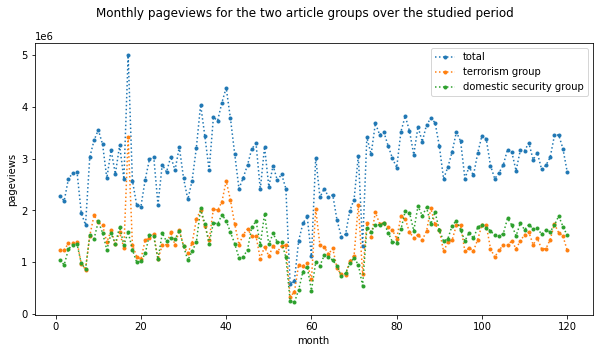

In [5]:
fig = plt.figure(figsize=(10, 5))

ax = monthly_views.sum().plot(fig=fig, style='.:', label='total')
terrorism_views.sum().plot(fig=fig, style='.:', label='terrorism group')
domestic_views.sum().plot(fig=fig, style='.:', label='domestic security group')

ax.set_xlabel('month')
ax.set_ylabel('pageviews')
plt.legend()
fig.suptitle('Monthly pageviews for the two article groups over the studied period');

We can see a strange drop of pageviews around month 55 (July 2014), let's try to understand it.

### Strange pageview drop around month 55

In [99]:
# We count the number of zeros for each article for each month
df['zeros'] = (df['views'] == 0).astype(int)
zeroes = df.groupby(['article', 'time'])['zeros'].mean().reset_index().pivot_table(index='article', columns='time', values='zeros')

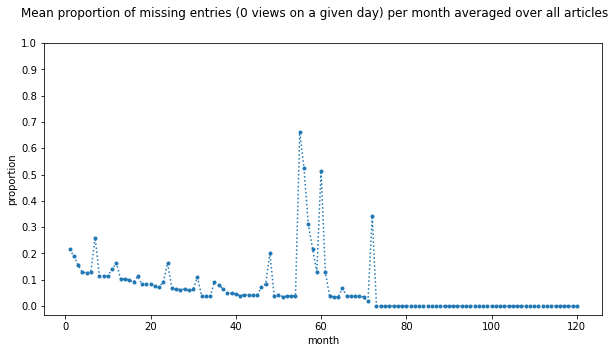

In [100]:
fig = plt.figure(figsize=(10, 5))

ax = zeroes.mean().plot(fig=fig, style='.:')

ax.set_xlabel('month')
ax.set_ylabel('proportion')
ax.set_yticks([i / 10 for i in range(11)])
fig.suptitle('Mean proportion of missing entries (0 views on a given day) per month averaged over all articles');

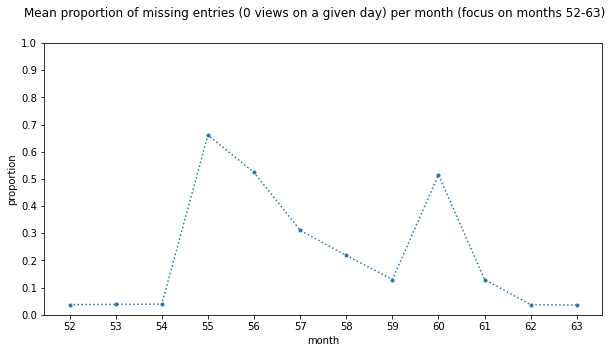

In [101]:
fig = plt.figure(figsize=(10, 5))

ax = zeroes.mean().loc[52:63].plot(fig=fig, style='.:')

ax.set_xlabel('month')
ax.set_xticks(range(52, 63+1))
ax.set_ylabel('proportion')
ax.set_yticks([i / 10 for i in range(11)])
fig.suptitle('Mean proportion of missing entries (0 views on a given day) per month (focus on months 52-63)');

This sudden increase in missing entries might be due to a Wikipedia outage during the months 54 to 60 (June to December 2014), or due to the unofficial API not having complete data for these months.

In any case, we will not consider these months during our ITS analysis as this would surely affect the results. To do so, in the regression we will simply drop the entries corresponding to the mentioned months, without shifting the month numbers after them.

### Looking for outliers

As in the original paper, many of the articles see sudden spikes in pageviews for some months, likely due to mediatized events such as conflicts and such.

In order to reduce the effects of sudden events like this and to focus only on

In [96]:
def four_panel_pageviews_plot(data, lang):
    """
    Helper function that allows to plot the monthly number of pageviews for a large number of articles
    by creating 4 subplots and distributing the data approximatively.
    Takes the DataFrame with the pageview Series and the language to plot i.
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 10))
    
    n = data.shape[0]

    data.T.iloc[:,          0:     n // 4].plot(ax=axes[0, 0])
    data.T.iloc[:,     n // 4: 2 * n // 4].plot(ax=axes[0, 1])
    data.T.iloc[:, 2 * n // 4: 3 * n // 4].plot(ax=axes[1, 0])
    data.T.iloc[:, 3 * n // 4:].plot(ax=axes[1, 1])

    axes[0, 0].set_ylabel('monthly pageviews')
    axes[1, 0].set_ylabel('monthly pageviews')

    axes[0, 0].legend(ncol=2)
    axes[1, 0].legend(ncol=2)
    axes[0, 1].legend(ncol=2)
    axes[1, 1].legend(ncol=2)

    fig.suptitle(f'[{lang}] Monthly pageviews of the {n} articles in both groups'
                 f' (split alphabetically into 4 subplots of around {n // 4} articles each).')

    fig.set_tight_layout(True)

In [21]:
# This is a dictionary from languages to the corresponding DataFrame of monthly views per article
views = {lang: df[df.language == lang].groupby(['article', 'time'])['views'].sum().reset_index()\
                                      .pivot_table(index='article', columns='time', values='views') for lang in df.language.unique()}

In [1]:
# This is a dictionary from language to list of outlier articles
outliers = {}

#### English

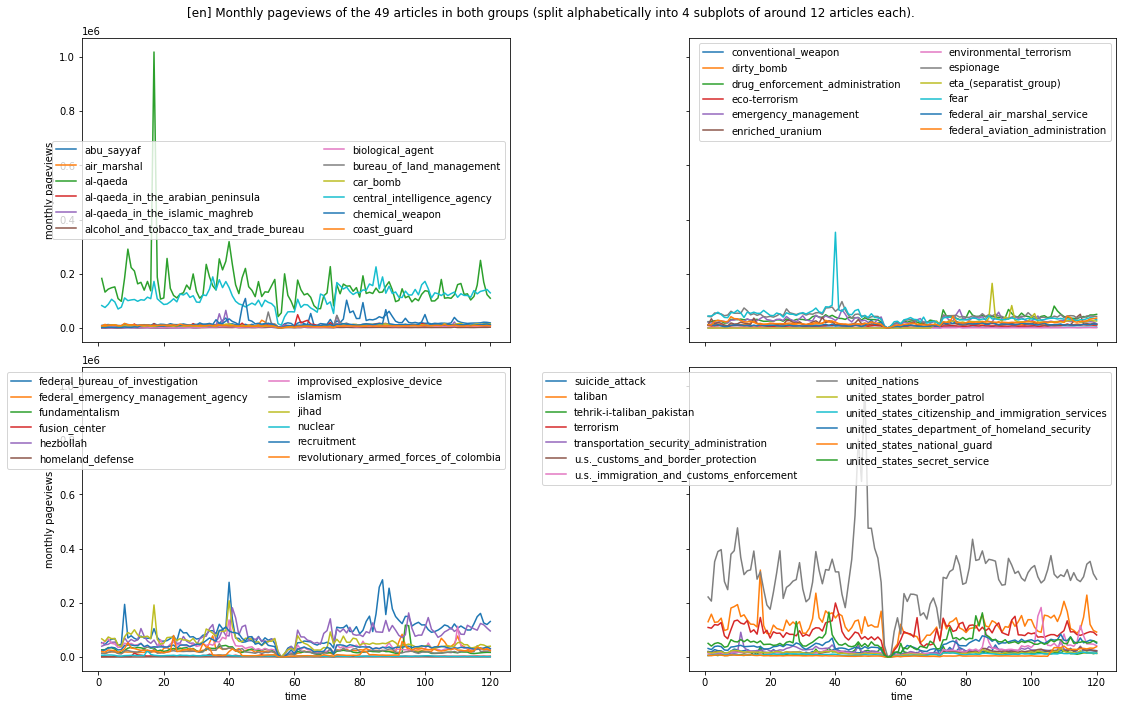

In [66]:
lang = 'en'
four_panel_pageviews_plot(views[lang], lang)

In [67]:
outliers[lang] = ['al-qaeda', 'united_nations', 'fear']

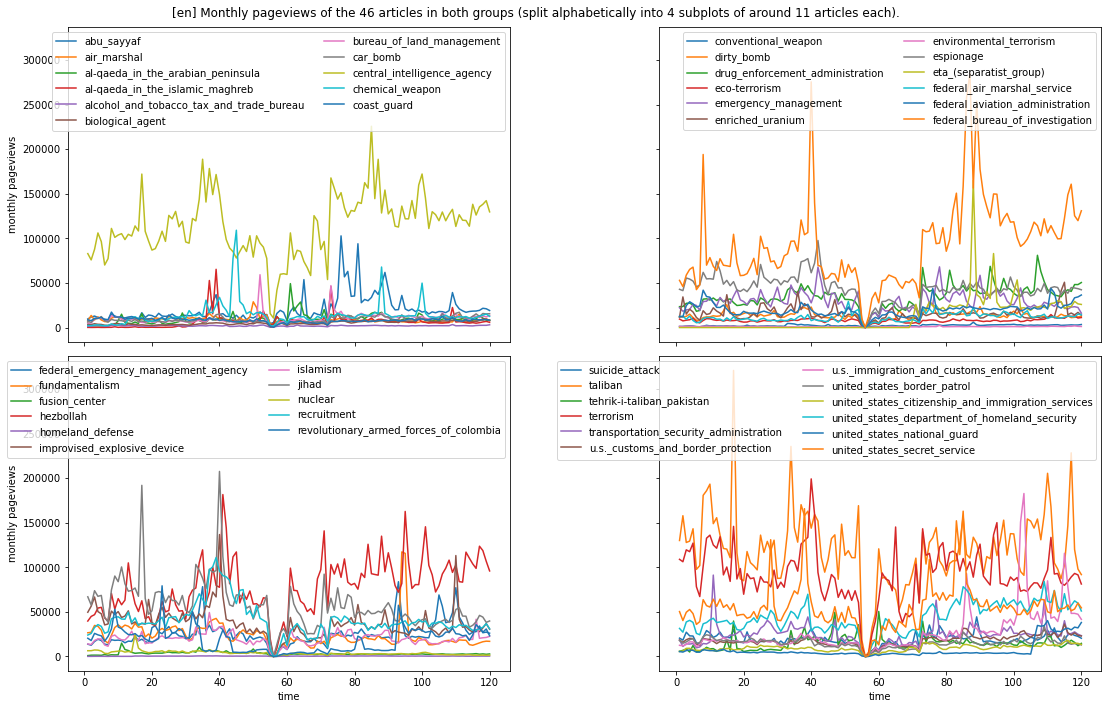

In [68]:
four_panel_pageviews_plot(views[lang].drop(outliers[lang]), lang)

#### German

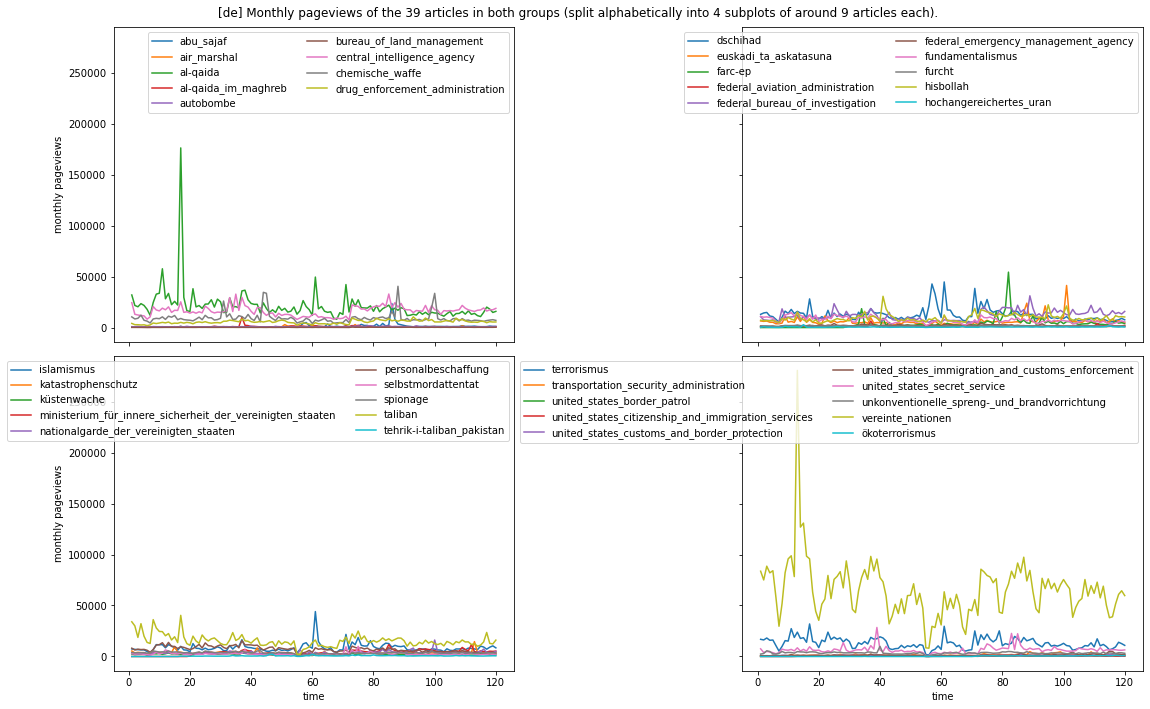

In [69]:
lang = 'de'
four_panel_pageviews_plot(views[lang], lang)

In [72]:
outliers[lang] = ['al-qaida', 'vereinte_nationen', 'islamismus']

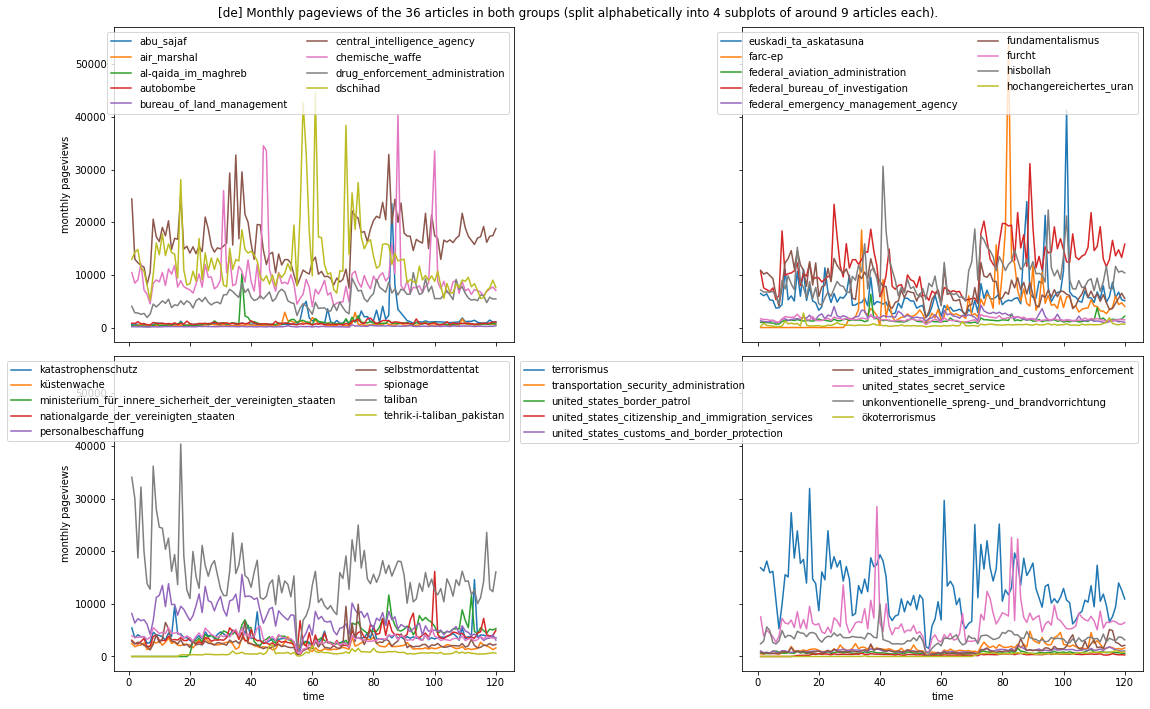

In [73]:
four_panel_pageviews_plot(views[lang].drop(outliers[lang]), lang)

#### French

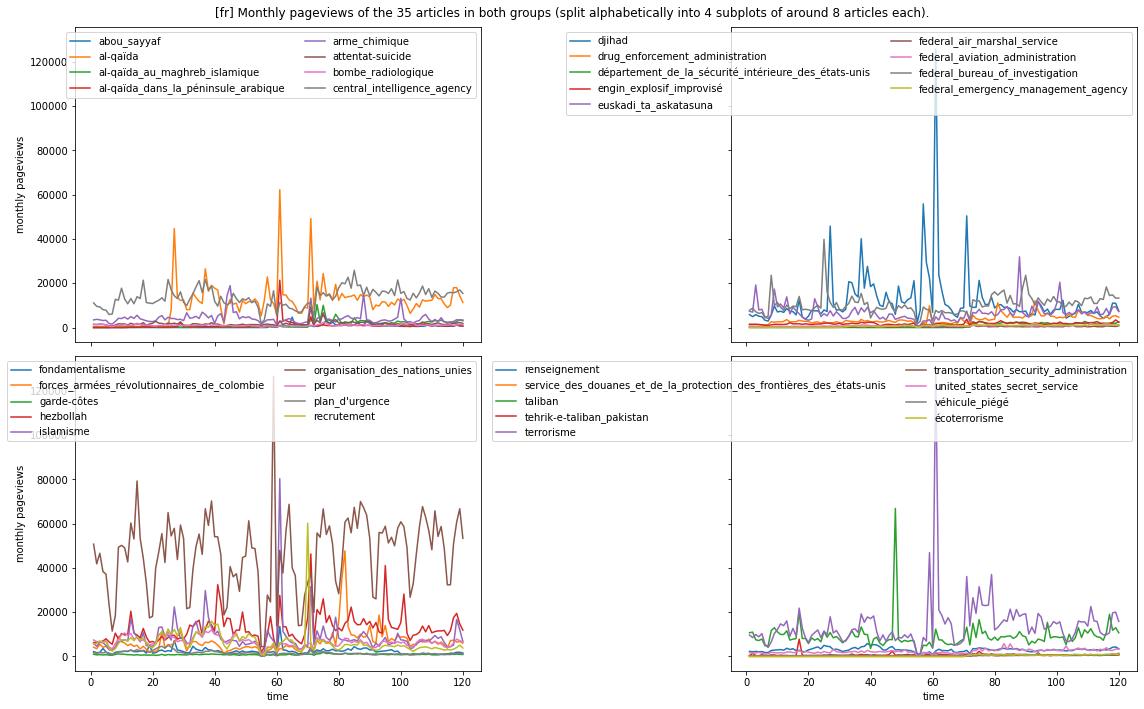

In [74]:
lang = 'fr'
four_panel_pageviews_plot(views[lang], lang)

In [75]:
outliers[lang] = ['djihad', 'islamisme', 'terrorisme', 'organisation_des_nations_unies', 'taliban', 'recrutement']

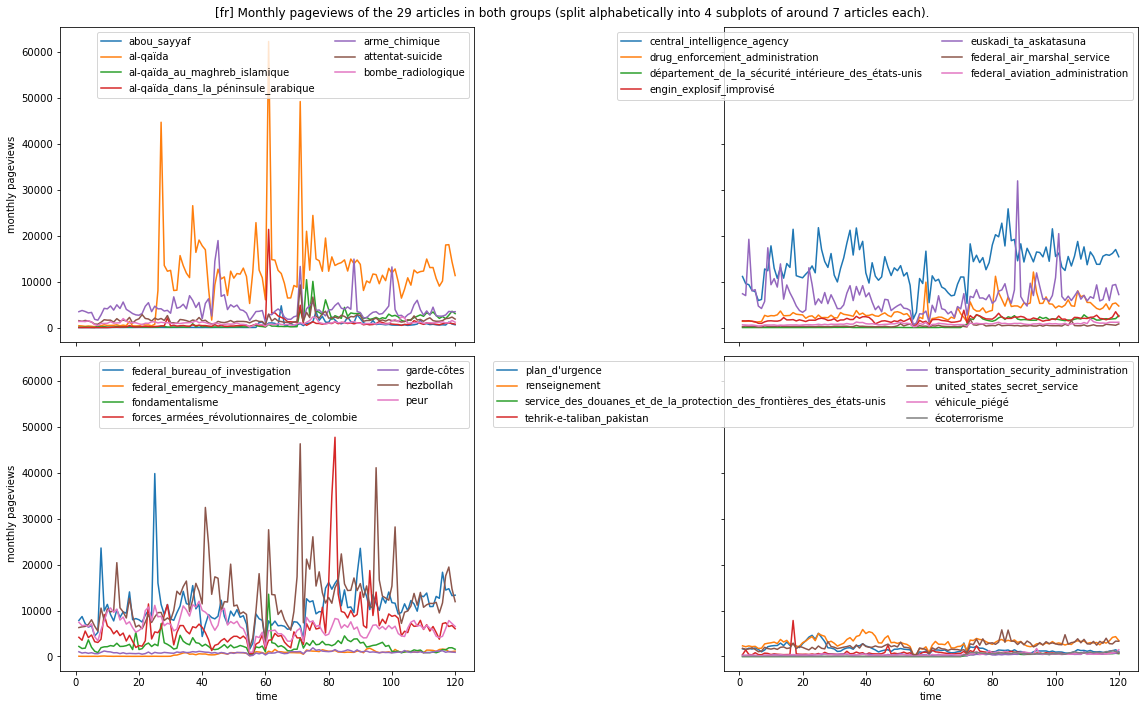

In [76]:
four_panel_pageviews_plot(views[lang].drop(outliers[lang]), lang)

#### Spanish

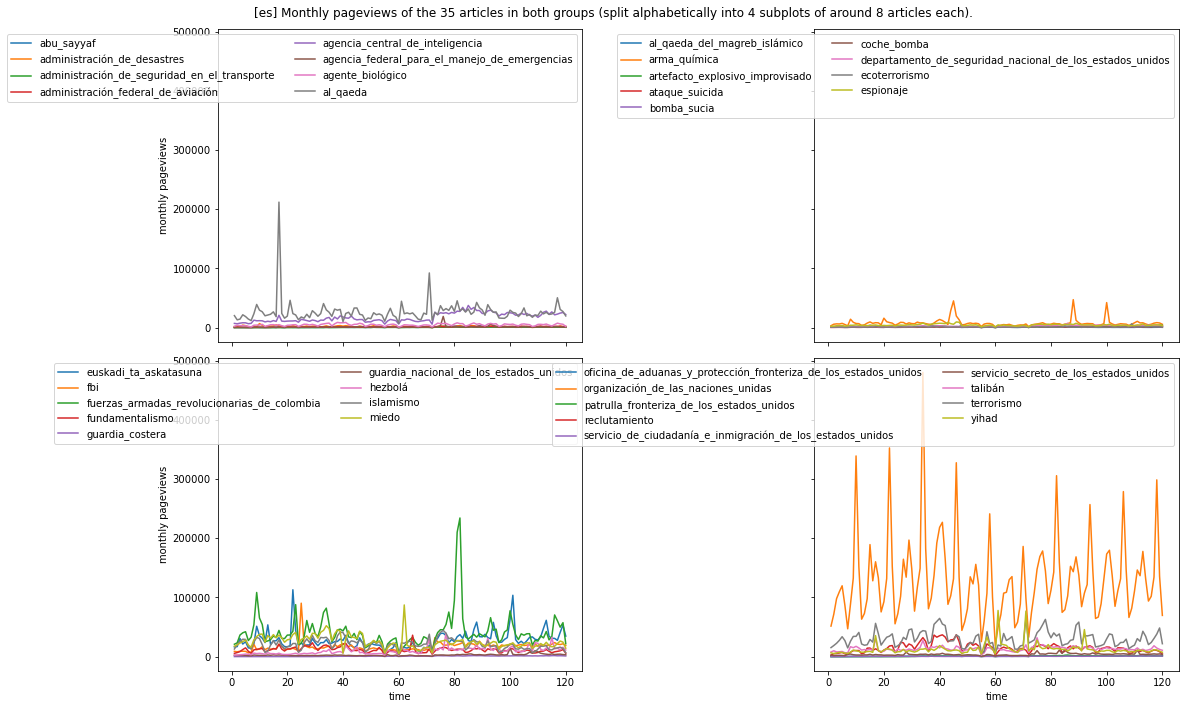

In [78]:
lang = 'es'
four_panel_pageviews_plot(views[lang], lang)

In [84]:
outliers[lang] = ['al_qaeda', 'fuerzas_armadas_revolucionarias_de_colombia', 'organización_de_las_naciones_unidas']

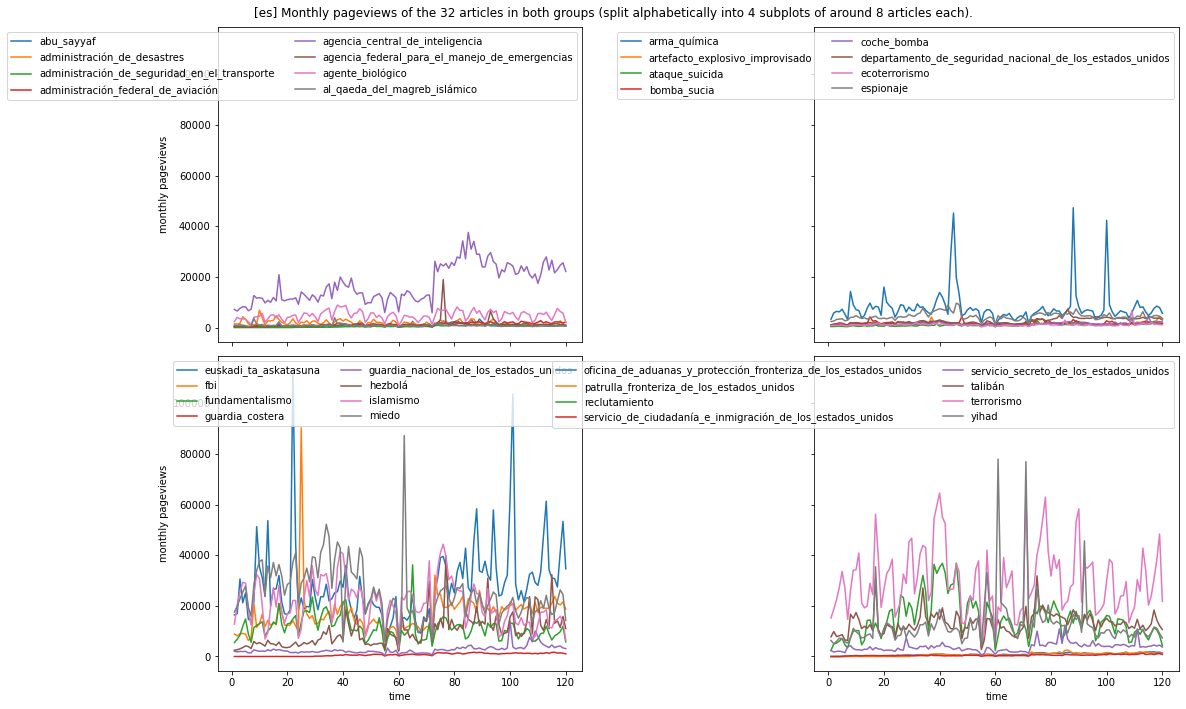

In [85]:
four_panel_pageviews_plot(views[lang].drop(outliers[lang]), lang)

#### Italian

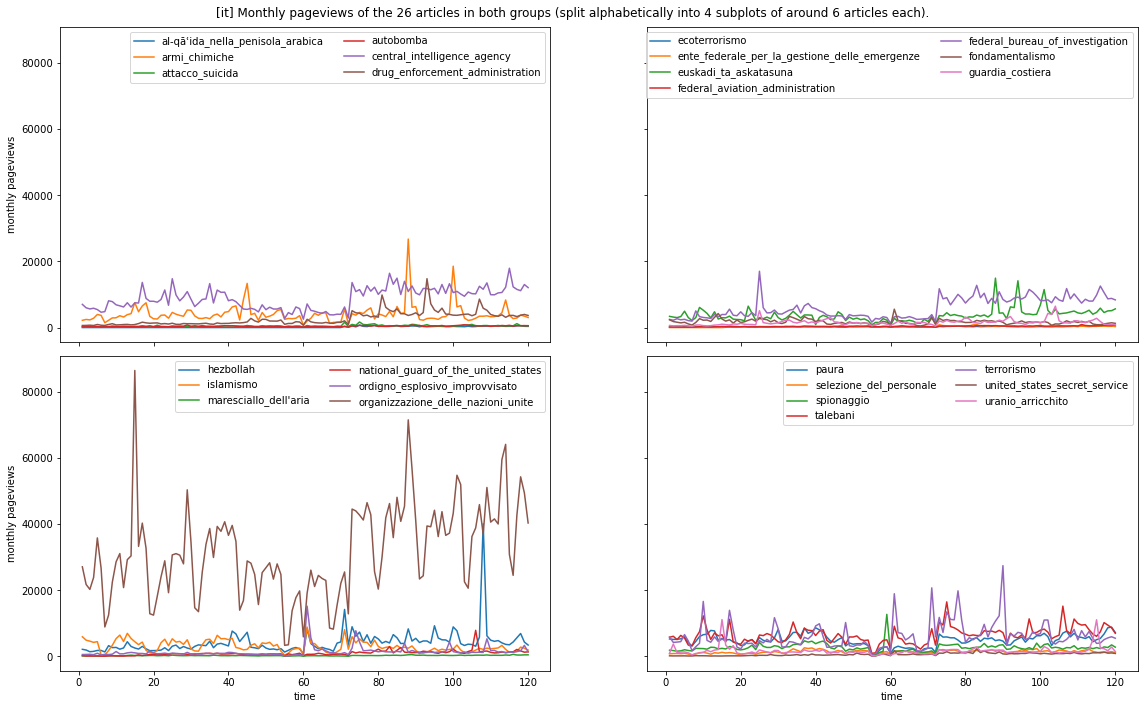

In [86]:
lang = 'it'
four_panel_pageviews_plot(views[lang], lang)

In [89]:
outliers[lang] = ['organizzazione_delle_nazioni_unite', 'hezbollah']

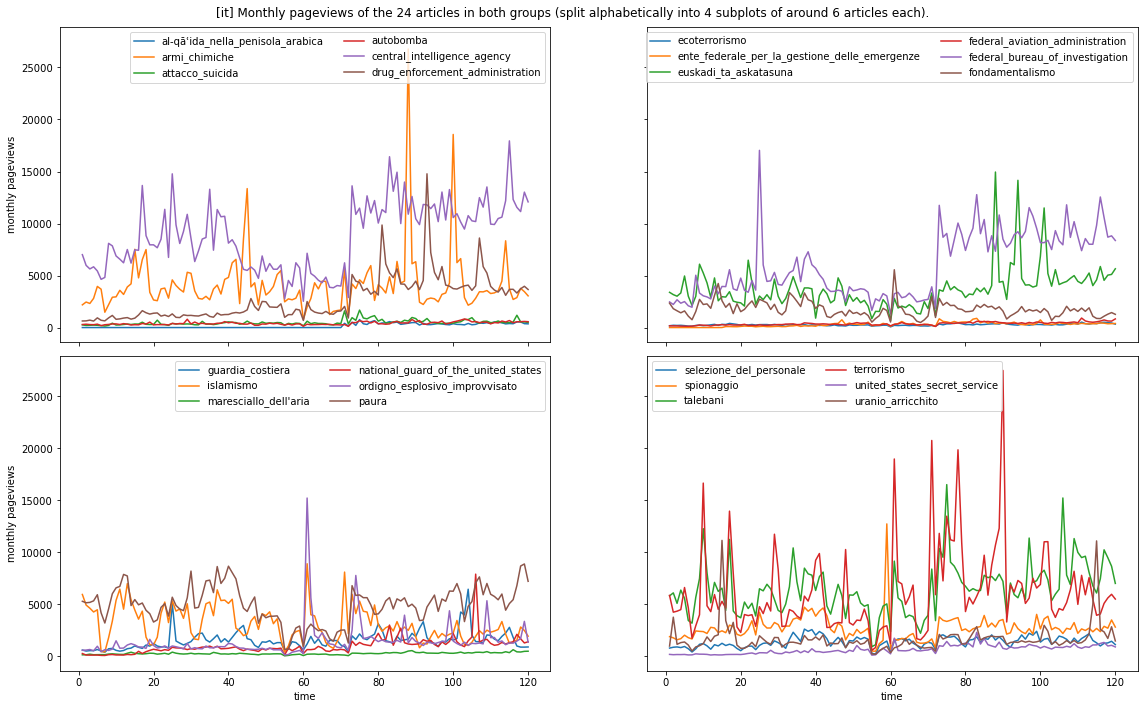

In [90]:
four_panel_pageviews_plot(views[lang].drop(outliers[lang]), lang)

#### Portuguese

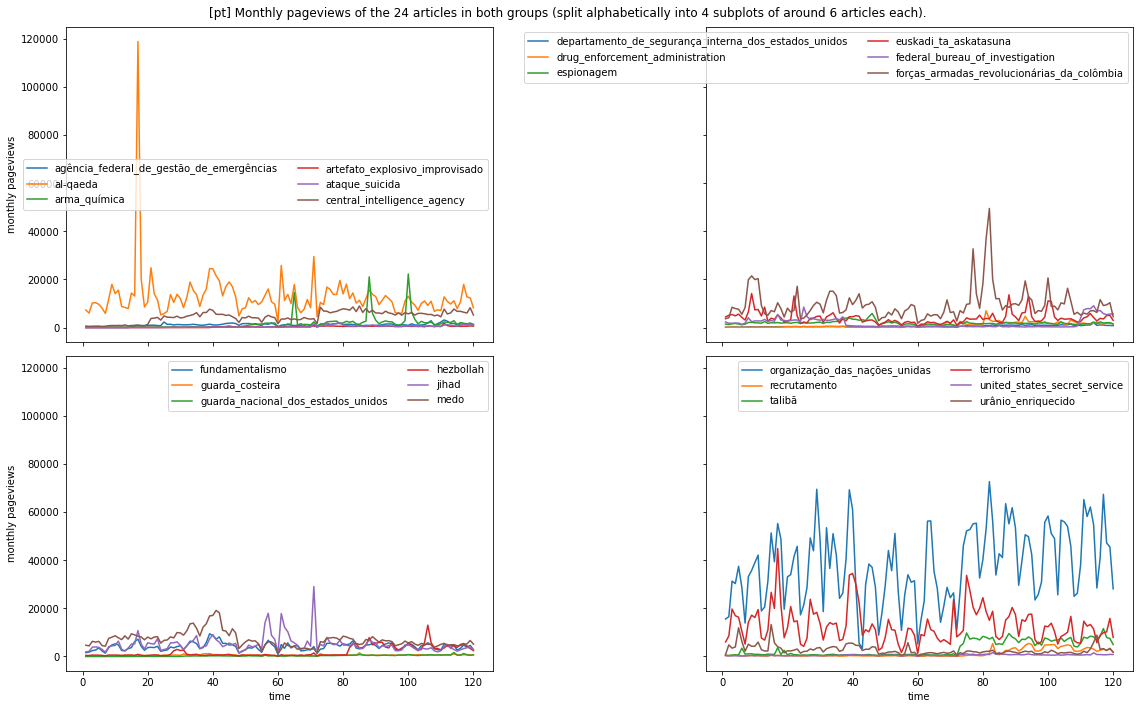

In [91]:
lang = 'pt'
four_panel_pageviews_plot(views[lang], lang)

In [94]:
outliers[lang] = ['al-qaeda', 'organização_das_nações_unidas', 'forças_armadas_revolucionárias_da_colômbia']

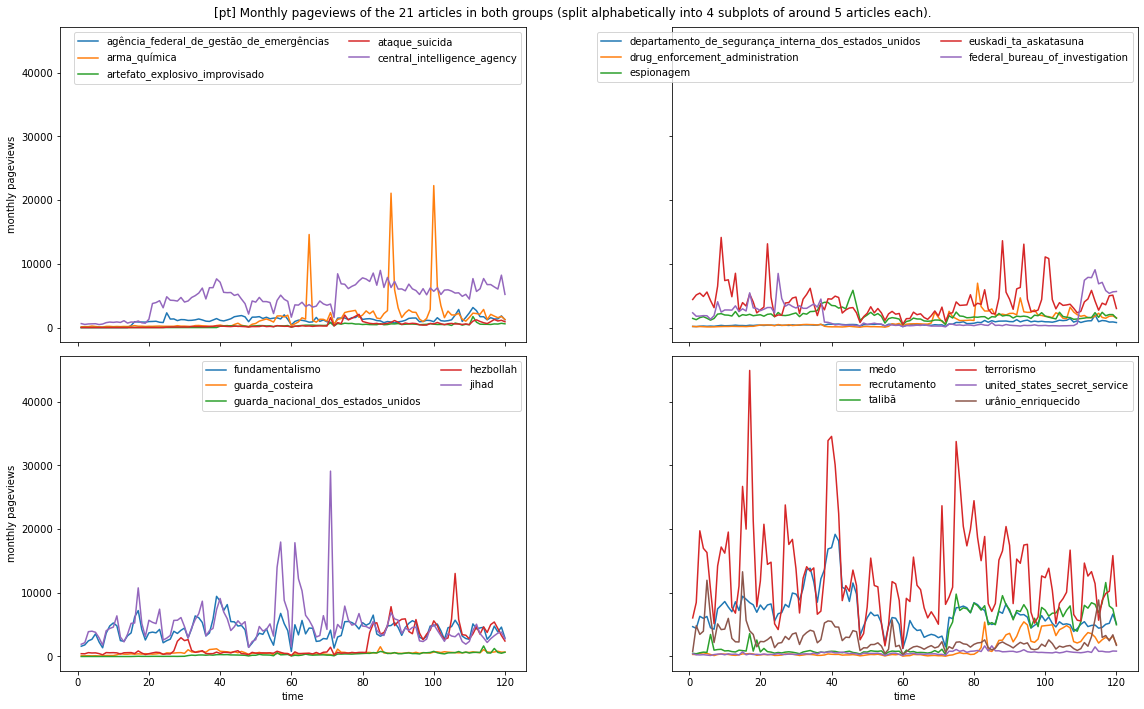

In [95]:
four_panel_pageviews_plot(views[lang].drop(outliers[lang]), lang)

In [111]:
def analyse_and_plot(dataset='wikipedia', lang=None, ignore_months=range(54, 60+1), split=42, stop=120, outliers=None):
    """
    outliers is a dictionary of language to list of article_names when it is not None
    (month 42 is June 2013 since the data starts in January 2010)
    """
    
    # Read both csv files
    df_terrorism = pd.read_csv(f'data/{dataset}/terrorism_views.csv')
    df_domestic = pd.read_csv(f'data/{dataset}/domestic_views.csv')
    
    # Group them
    df = pd.concat([df_terrorism, df_domestic])
    
    # Maybe drop outliers
    if outliers is not None:
        for l, outs in outliers.items():
            for out in outs:
                df = df[(df.language != l) | ((df.language == l) & (df.article != out))]
    
    # Create a mapping from article name to study group
    group = {}
    for article in df_terrorism.article.unique():
        group[article] = 'terrorism'
    for article in df_domestic.article.unique():
        group[article] = 'domestic'
    
    if lang is not None:
        # Keep only articles in this language
        df = df.loc[df.language == lang]
    
    # We extract the month, year, time (number of months elapsed since the beginning of the period)
    df['month'] = pd.DatetimeIndex(df.date).month
    df['year'] = pd.DatetimeIndex(df.date).year
    df['time'] = (df.year - df.year.min()) * 12 + df.month
    
    # We count the number of zeros for each article for each month
    df['zeros'] = (df['views'] == 0).astype(int)
    zeroes = df.groupby(['article', 'time'])['zeros'].mean().reset_index()\
               .pivot_table(index='article', columns='time', values='zeros')
    
    
    # Get the total number of views for each article for each month
    monthly_views = df.groupby(['article', 'time'])['views'].sum().reset_index()\
                      .pivot_table(index='article', columns='time', values='views')
    
    # Retrieve the monthly pageviews for each article group
    terrorism_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'terrorism')]
    domestic_views = monthly_views.loc[monthly_views.index.map(lambda art: group[art] == 'domestic')]
    
    # DataFrame to apply the ITS analysis to
    its = pd.DataFrame()

    # Monthly number of views aggregated over all terrorism articles
    its['t_views'] = terrorism_views.sum()[:stop]
    # Monthly number of views aggregated over all terrorism articles
    its['d_views'] = domestic_views.sum()[:stop]
    # Indicator of whether the NSA revelations have already happened
    its['NSA'] = (its.index.to_series() >= split).astype(int)
    # We just do this to be able to use the column 'month' in the regression
    its['month'] = its.index
    
    # Fitting the ITS regressions
    terrorism_regr = smf.ols(formula='t_views ~ month * NSA', data=its.drop(ignore_months)).fit()
    domestic_regr = smf.ols(formula='d_views ~ month * NSA', data=its.drop(ignore_months)).fit()
    
    # Retrieve the ITS predictions and confidence intervals
    its['t_pred'] = terrorism_regr.predict(its)
    its[['t_low', 't_high']] = terrorism_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values
    its['d_pred'] = domestic_regr.predict(its)
    its[['d_low', 'd_high']] = domestic_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values
    
    
    ## Plotting
    fig = plt.figure(figsize=(16, 8))
    plt.ticklabel_format(axis='y', style='plain')

    # Plot the actual monthly pageviews as dots
    plt.plot(its['t_views'].drop(ignore_months), 'o', label='terrorism article views')
    plt.plot(its['t_views'].loc[ignore_months[:-1]], 'o', color='paleturquoise', label='ignored terrorism entries')

    plt.plot(its['d_views'].drop(ignore_months), 'o', label='domestic article views')
    plt.plot(its['d_views'].loc[ignore_months[:-1]], 'o', color='navajowhite', label='ignored domestic entries')

    
    # Plot the regression line before the June 2013 revelations (June 2013 excluded)
    plt.plot(its.loc[:split-1, 't_pred'], 'k-', label='trend before NSA revelations')
    # Plot the regression line after the June 2013 revelations (June 2013 included)
    plt.plot(its.loc[split:, 't_pred'], 'k--', label='trend after NSA revelations')

    # Plot the regression line before the June 2013 revelations (June 2013 excluded)
    plt.plot(its.loc[:split-1, 'd_pred'], 'k-')
    # Plot the regression line after the June 2013 revelations (June 2013 included)
    plt.plot(its.loc[split:, 'd_pred'], 'k--')

    # Plot the regression confidence intervals
    plt.fill_between(its.loc[:split-1].index, its.loc[:split-1]['t_low'], its.loc[:split-1]['t_high'],
                     alpha=0.3, color='mediumturquoise', label='terrorism 95% CI')
    plt.fill_between(its.loc[split:].index, its.loc[split:]['t_low'], its.loc[split:]['t_high'],
                     alpha=0.3, color='mediumturquoise')

    plt.fill_between(its.loc[:split-1].index, its.loc[:split-1]['d_low'], its.loc[:split-1]['d_high'],
                     alpha=0.3, color='orange', label='domestic 95% CI')
    plt.fill_between(its.loc[split:].index, its.loc[split:]['d_low'], its.loc[split:]['d_high'],
                     alpha=0.3, color='orange')

    # Show the moment of the NSA revelations
    plt.axvline(x=split-0.5, color='r', label='NSA revelations (June 2013)')

    # Show legend, set title, axis labels, x ticks
    plt.legend(ncol=5)
    plt.title(f'[{lang if lang is not None else "all languages"} | {dataset}] Terrorism study group (25 articles)'
              ' vs Domestic security comparator group (24 articles)')
    plt.xlabel('time (month)')
    plt.xticks(range(0, stop+1, 6))
    plt.ylabel('total pageviews')
    
    # Return the regression and the figure
    return (terrorism_regr, domestic_regr), fig

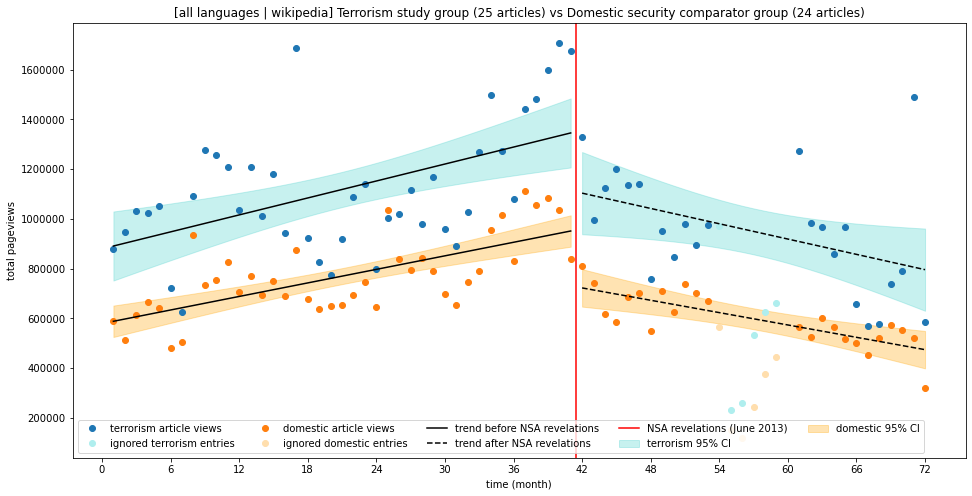

In [112]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', stop=72, outliers=outliers)

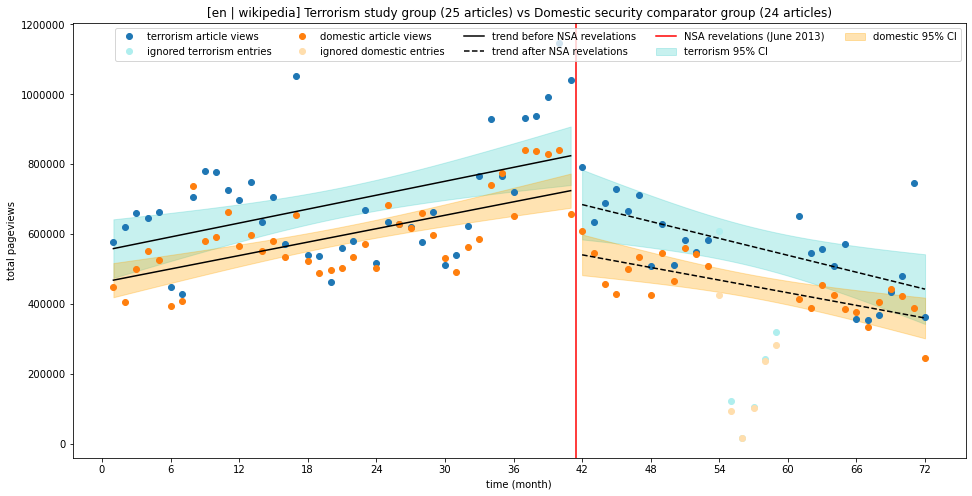

In [113]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='en', stop=72, outliers=outliers)

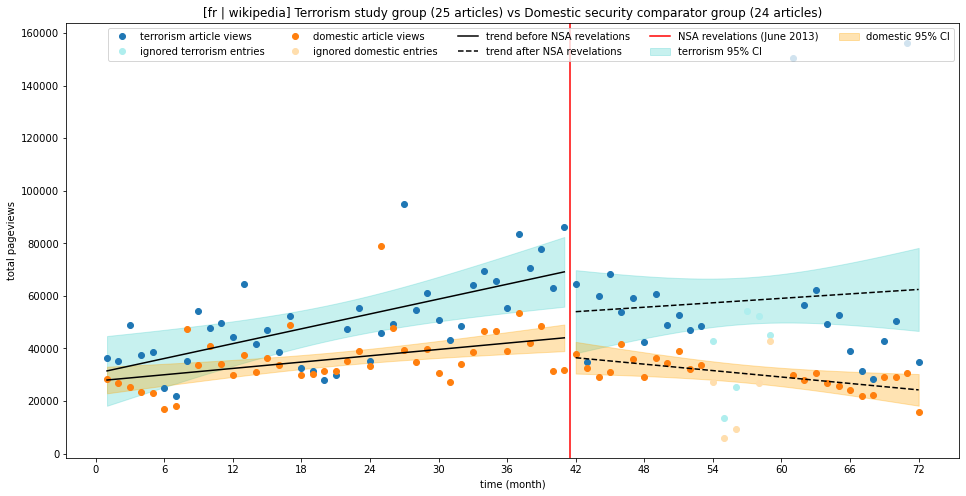

In [114]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='fr', stop=72, outliers=outliers)

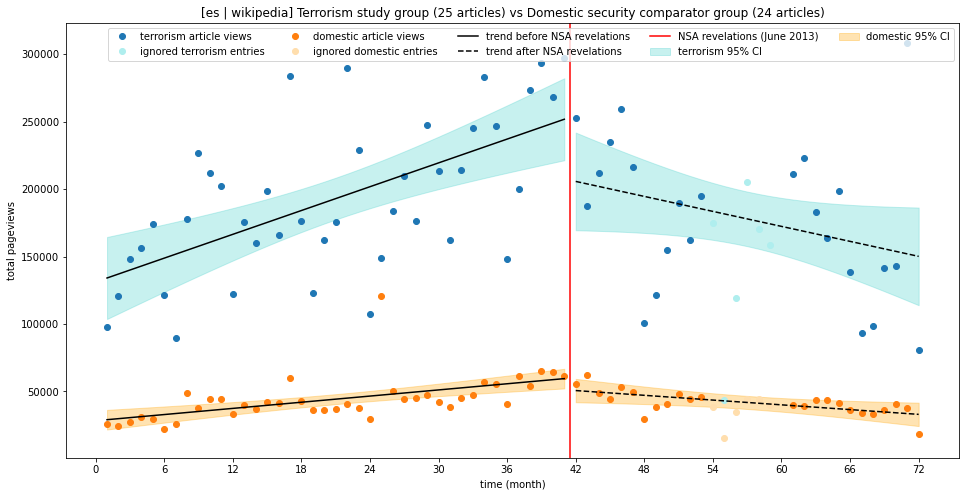

In [115]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='es', stop=72, outliers=outliers)

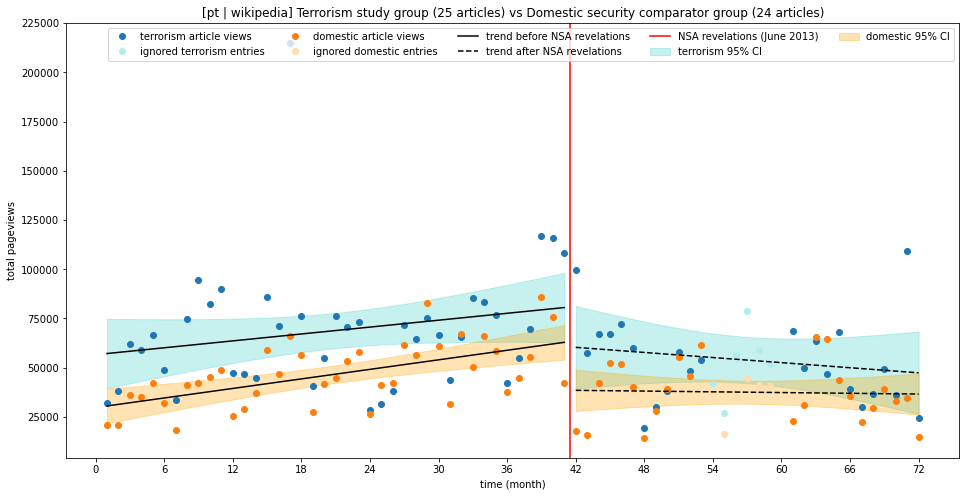

In [17]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='pt', stop=72)

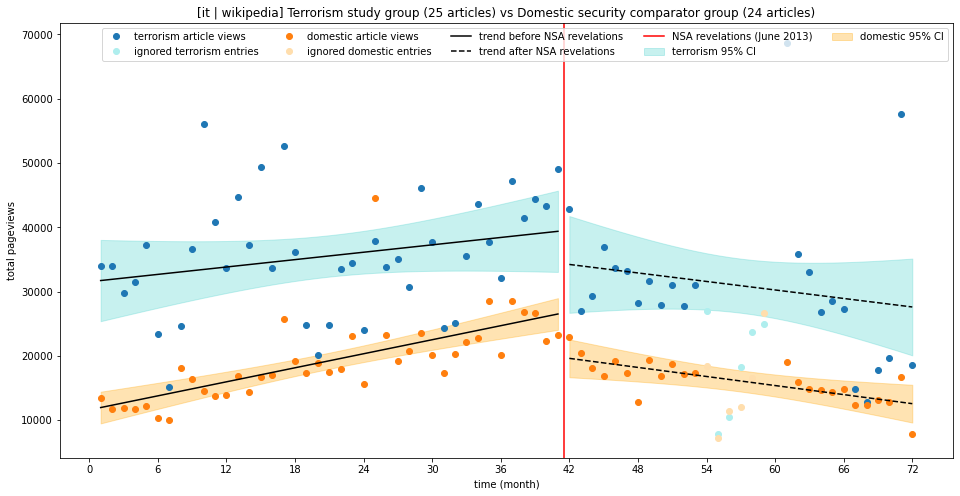

In [116]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='it', stop=72, outliers=outliers)

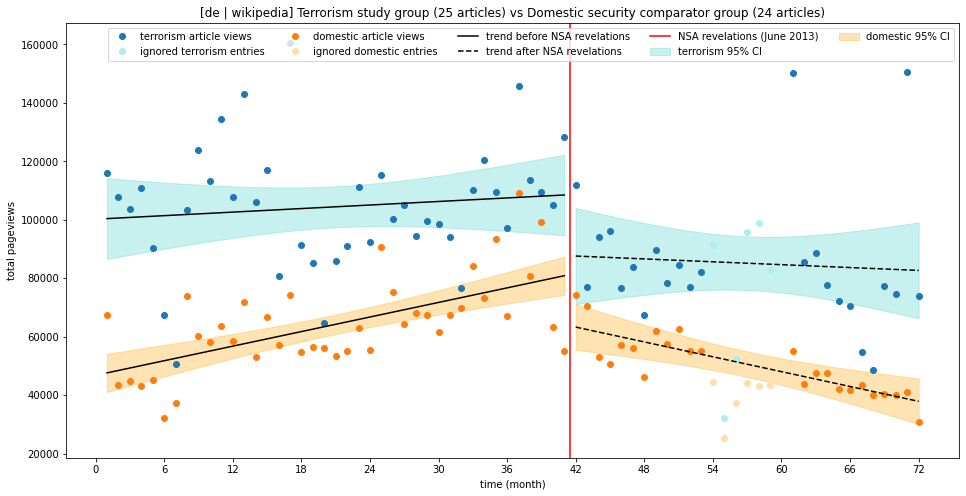

In [117]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('wikipedia', lang='de', stop=72, outliers=outliers)

## Exploring the Google Trends Data

In [136]:
monthly_interest = google.groupby(['article', 'month', 'topic']).sum().reset_index().set_index('month')
terror = monthly_interest.loc[monthly_interest.topic == 'terror'].groupby('month').sum()
domestic = monthly_interest.loc[monthly_interest.topic == 'domestic'].groupby('month').sum()

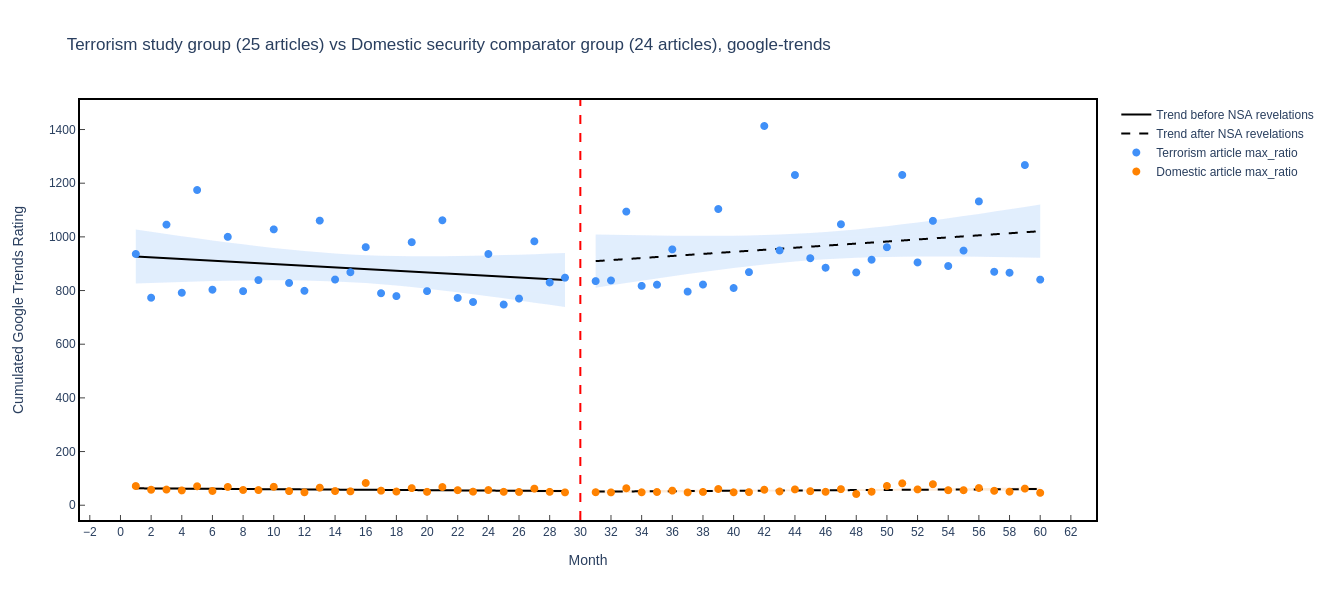

In [134]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('google-trends', ignore_months=[], layout=google_layout)
fig.show()

There seem to be no major anomalies in the data, but a closer look can never hurt. Especially the terror peak in June 2014 might be worth a closer observation. So first, let's see which articles contributed the most to the high count and how much larger the interest in those articles were than usually:

In [135]:
jun14 = monthly_interest.loc['2014-06']
mean_ratio = monthly_interest.groupby('article')['max_ratio'].mean()
interest_increase = jun14.apply(lambda row: row['max_ratio'] / mean_ratio[row['article']], axis=1)
jun14.insert(loc=5, column='interest_increase', value=interest_increase)
jun14.loc[jun14.topic == 'terror'].sort_values(by='max_ratio', ascending=False).head(5)

article   topic   max_ratio  max_ratio_hi  max_ratio_lo  \
month                                                                  
2014-06      nigeria  terror  314.710941    343.654875    288.442681   
2014-06     pakistan  terror  204.658649    225.296399    186.005093   
2014-06       attack  terror  183.420487    202.455289    166.236436   
2014-06         iran  terror  164.113067    181.690644    148.264929   
2014-06  recruitment  terror  142.231325    150.761306    134.276435   

         interest_increase  
month                       
2014-06           2.993572  
2014-06           1.140807  
2014-06           1.324042  
2014-06           2.886248  
2014-06           1.278841

We can see that especially the articles nigeria and iran seem to trigger a highly increased interest in this month. But why is that?
Nigeria suffered from bombings and many deaths in June 2014 due to the Islamist insurgency that started in 2009 but seemed to reach a peak in the summer of 2014.

Another reason for the increased interest could be something completely different: The 2014 FIFA World Cup. Both countries, Nigeria and Iran had teams participate and Nigeria even managed to get into the knockout stage. The world cup usually has a huge public resonance. The 2014 one for example ranks as the 10th-most watched television broadcast of all times - it seems to be reasonable that the interest int participating countries also automatically increases.

Whatever reason caused the rising interest for terror-related articles in 2014, it seems to be safer to ignore this month in the analysis and consider it an outlier.

In [142]:
# monthly_interest.drop(monthly_interest.loc[['2013-06', '2014-06']].index, inplace=True)
ignore = (2014 - monthly_interest.index.min().year) * 12 + 6 - (monthly_interest.index.min().month - 1)

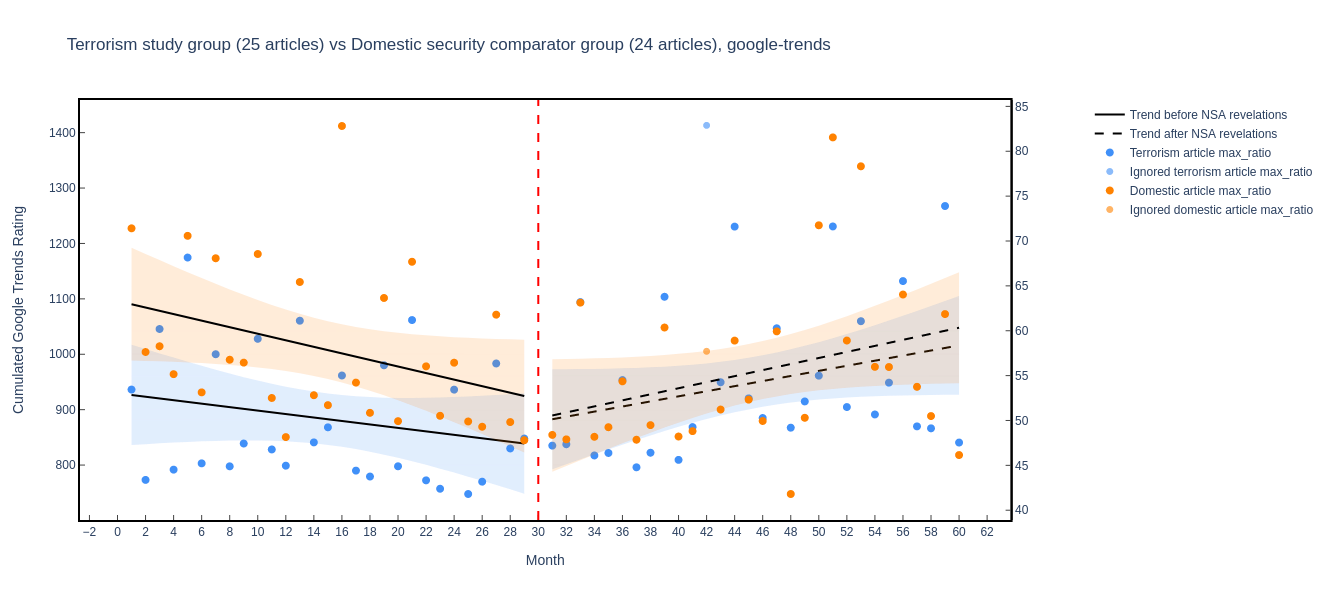

In [162]:
(terrorism_regr, domestic_regr), fig = analyse_and_plot('google-trends', ignore_months=[ignore], layout=google_layout, seperate_y=True)
fig.show()

## Regression

In [ ]:
# DataFrame to apply the ITS analysis to
its = pd.DataFrame()

# Monthly number of views aggregated over the 46 terrorism articles
its['terrorism_views'] = terrorism_clean.sum()
# Monthly number of views aggregated over the 24 domestic articles
its['domestic_views'] = domestic_clean.sum()

# Indicator of whether the NSA revelations have already happened (month 42 is June 2013)
its['NSA'] = (its.index.to_series() >= 42).astype(int)
# We just do this to be able to use the column 'month' in the regression
its['month'] = its.index
its.head(3)

In [ ]:
terrorism_regr = smf.ols(formula='terrorism_views ~ month * NSA', data=its.drop(range(54, 60+1))).fit()
print(terrorism_regr.summary())
its['terrorism_regr'] = terrorism_regr.predict(its)
its[['terrorism_lower', 'terrorism_upper']] = terrorism_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values

In [ ]:
domestic_regr = smf.ols(formula='domestic_views ~ month * NSA', data=its.drop(range(54, 60+1))).fit()
print(domestic_regr.summary())
its['domestic_regr'] = domestic_regr.predict(its)
its[['domestic_lower', 'domestic_upper']] = domestic_regr.get_prediction(its).summary_frame(alpha=0.05).iloc[:, 2:4].values

## Interactive Plots with Plotly

In [ ]:
fig = language_overview()
fig.show()